This Notebook will go over Feature extraction , some Visualization and Modeling
lets start with imports and loading the main class Molecules that works on a directory with feather files,
we will use the example in the package.
Change ROOT_DIR accordingly.


In [88]:
%reset -f
%reload_ext autoreload
%autoreload 2

import os
import sys
import importlib
import numpy as np
import pandas as pd

# === Setup ===
ROOT_DIR = r'C:\Users\edens\Documents\GitHub\LabCode\MolFeatures'
sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'M3_modeler'))
sys.path.append(os.path.join(ROOT_DIR, 'M2_data_extractor'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))

os.chdir(ROOT_DIR)  # Set working directory

# === Clear old module caches ===
for module in ['data_extractor', 'feather_extractor', 'gaussian_handler', 'help_functions', 'modeling', 'plot']:
    sys.modules.pop(module, None)

# === Safe Imports ===
try:
    from data_extractor import Molecules, extract_connectivity
    from feather_extractor import logs_to_feather
    import gaussian_handler
    from gaussian_handler import feather_file_handler
    from help_functions import dict_to_horizontal_df, get_df_from_file, pick_samples_to_remove_for_distribution
    import help_functions
    import visualize
    from modeling import (
        ClassificationModel,
        LinearRegressionModel,
        fit_and_evaluate_single_combination_regression,
        fit_and_evaluate_single_combination_classification
        
    )
    import plot
except ModuleNotFoundError as e:
    print(f"Module import failed: {e}")

# === Config ===
pd.set_option('display.max_columns', None)

# === Load molecular data ===
feather_path = r'C:\Users\edens\Documents\GitHub\lucas_project\new_logs_hirshfeld\new_feather\test\feather_files'



In [89]:
mols = Molecules(feather_path)

Molecules Loaded: ['BMNM_8.feather', 'molecule_6.feather', 'p49.feather', 'thiol_2 (1).feather'] Failed Molecules: []


Great we can see the files Loaded ! 
lets print the methods for the mols object we created to see what wee can use.

In [58]:
methods=[method for method in dir(mols) if not method.startswith('_')]
print(methods)

['export_all_xyz', 'extract_all_dfs', 'extract_all_xyz', 'failed_molecules', 'filter_molecules', 'get_bend_vibration_dict', 'get_bond_angle_dict', 'get_bond_length_dict', 'get_charge_df_dict', 'get_charge_diff_df_dict', 'get_dipole_dict', 'get_molecules_comp_set_app', 'get_npa_dict', 'get_ring_vibration_dict', 'get_sterimol_dict', 'get_stretch_vibration_dict', 'molecules', 'molecules_names', 'molecules_path', 'old_molecules', 'old_molecules_names', 'success_molecules', 'visualize_molecules', 'visualize_smallest_molecule', 'visualize_smallest_molecule_morfeus']


In [19]:
for mol in mols.molecules:
    # replace nan in atoms with Pd not NaN
    mol.xyz_df['atom'] = mol.xyz_df['atom'].replace('nan', 'Pd')

Great now lets use visualize_molecules to see the first molecule of the set.


In [24]:
mols.visualize_molecules([0])

🔥 dipole vector: array([ 0.    , -2.2062,  0.    ]) (scaled by 2)


In [90]:
sss = mols.get_stretch_vibration_dict([6,8], threshold=1700)
sss
# === Example of using the Molecules class ===


Calculating stretch vibration for atoms [6, 8] with threshold 1700 
 Remember : ALWAYS LOOK AT THE RESULTING VIBRATION
Directionality check: [0.23 0.45 0.16] vs [ 0.23 -0.45  0.16] ===> -0.4412811387900355
Directionality check: [-0.39 -0.35 -0.25] vs [ 0.39 -0.35  0.25] ===> -0.27321269652921987
Directionality check: [-0.2  -0.31 -0.14] vs [-0.2   0.31 -0.14] ===> -0.2344251766217083
Directionality check: [0.2  0.27 0.14] vs [-0.2   0.27 -0.14] ===> 0.10037735849056609
                        Frequency  Amplitude
symmetric_Stretch_6_8   1752.4203   1.152019
asymmetric_Stretch_6_8  1783.6602   1.152019 
We strongly recommend to visualize the vibration modes to confirm the symmetry/asymmetry.
Strech Vibration Error: the following bonds do not exist-check atom numbering in molecule: 
 molecule_6 for [6, 8] 

Strech Vibration Error: the following bonds do not exist-check atom numbering in molecule: 
 p49 for [6, 8] 

Strech Vibration Error: the following bonds do not exist-check atom numbe

{'BMNM_8':                         Frequency  Amplitude
 symmetric_Stretch_6_8   1752.4203   1.152019
 asymmetric_Stretch_6_8  1783.6602   1.152019,
 'molecule_6':             Frequency Amplitude
 Stretch_6_8       NaN       NaN,
 'p49':             Frequency Amplitude
 Stretch_6_8       NaN       NaN,
 'thiol_2 (1)':             Frequency Amplitude
 Stretch_6_8       NaN       NaN}

Now that we see the molecules and atom numbering we can extract features. Remember it need to be numbered the same across the set !

In [92]:
answers_dict = {
    "Ring Vibration atoms - by order -> Pick primary atom and para to it: \n example: 13,17": [9, 8],
    "Stretch Threshold": [1600],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [],
    "Bend Threshold": [3000],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7": [17, 18],
    "Center_Atoms Dipole": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[11, 6, 4], [10, 11, 12], [11, 12, 5], [4, 5, 1], [4, 3, 2],[1,2,3]],
    "Sub-Atoms NPA": [1, 3, 5, 11, 8, 12, 14, 4, 6] ,
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [[11, 6, 4], [10, 11, 12], [11, 12, 5], [4, 5, 1], [4, 3, 2]],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [3,5,11,12,4,6,20,21,22,7],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [[3, 5], [5, 12], [11, 5], [3, 11]],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[4,6], [6, 4]],
    'drop_atoms - Atoms to drop: \n example: 1,2,3': [12,20,21,22,23,24,25,26],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[11, 6], [6, 4], [1, 5], [11, 6],[22,23]],
    'Bond_angle - Atom triplets to calculate difference: \n example: 1,2,3 4,5,6': [[11, 6, 4], [6, 4, 5], [1, 5, 4], [11, 6, 4]],
}
df=mols.get_molecules_features_set(entry_widgets=answers_dict,answers_list=None)

No benzene ring found.
Debug: Found 0 benzene rings
     0   1
0    1   2
1    1   5
2    1   8
3    2   3
4    3   4
5    3  11
6    3  15
7    4   5
8    4  13
9    4  20
10   6   8
11   6  10
12   7   8
13   7   9
14   9  10
15   9  12
16   9  28
17  10  14
18  10  17
19  15  16
20  15  24
21  15  25
22  16  20
23  16  30
24  17  29
25  17  31
26  18  19
27  18  20
28  18  23
29  22  23
30  22  27
31  22  30
32  23  26
33  28  29
34  28  39
35  28  40
36  29  33
37  21  30
38  31  32
39  31  37
40  33  34
41  33  35
42  35  36
43  35  37
44  37  38
Debug: Rings containing atom 8: []
Debug: No rings found containing both atoms 9 and 8
[ERROR] Error in get_ring_vibrations (get_benzene_ring_indices): cannot unpack non-iterable NoneType object
No benzene ring found.
Debug: Found 0 benzene rings
    0   1
0   1   2
1   1  10
2   1  11
3   2   3
4   2   7
5   3   4
6   3  12
7   3  13
8   4   5
9   4  14
10  5   6
11  5  15
12  6  16
13  7   8
14  7   9
15  9  17
Debug: Rings containing a

interactive(children=(FloatSlider(value=0.9, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…


Perfectly correlated feature pairs (|corr|=1):
            Feature 1         Feature 2  Correlation  Perfect
0    dip_x_NPA_11-6-4        nbo_atom_3          1.0     True
1    dip_x_NPA_11-6-4        nbo_atom_5         -1.0     True
2    dip_x_NPA_11-6-4       nbo_atom_12         -1.0     True
3    dip_x_NPA_11-6-4        nbo_atom_4          1.0     True
4    dip_x_NPA_11-6-4       nbo_atom_21         -1.0     True
..                ...               ...          ...      ...
149        nbo_atom_7      nbo_diff_3-5         -1.0     True
150        nbo_atom_7     nbo_diff_5-12         -1.0     True
151        nbo_atom_7  angle_[11, 6, 4]          1.0     True
152        nbo_atom_7   angle_[6, 4, 5]          1.0     True
153        nbo_atom_7               iso         -1.0     True

[154 rows x 4 columns]

Other highly correlated pairs:
              Feature 1         Feature 2  Correlation  Perfect
154  dip_y_NPA_10-11-12        nbo_atom_4    -1.000000    False
155     dip_z_NPA_4-3-2 

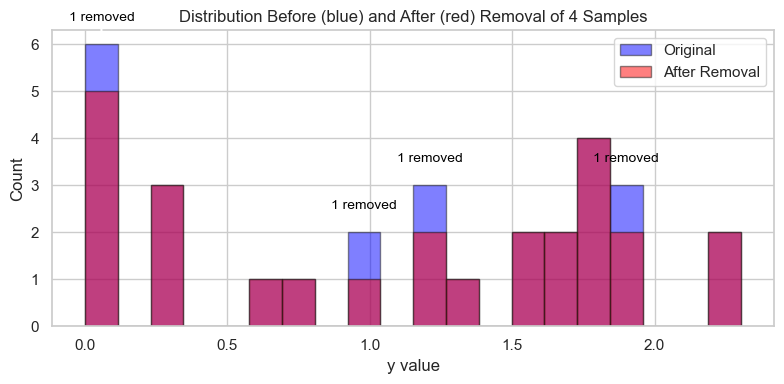

Samples to leave out: [20, 0, 2, 12]
Database already exists at: results_added_features_new_version.db
Table 'regression_results' has been ensured to exist.
linear model selected

--- Correlation Report ---
Features with correlation above 0.8:
['loc_B5_19-18', 'loc_B5_1-5', 'B1_11-6', 'L_4-6', 'B5_20-9', 'loc_B5_6-4', 'B1_19-18', 'B1_20-9', 'L_1-5', 'cross', 'cm5_atom_12', 'dipole_x_10-11-12', 'para_angle', 'B5_6-4', 'bond_length_12-14', 'loc_B5_4-6', 'Amplitude_Stretch_5_4', 'L_11-6', 'cross_angle', 'bite_angle', 'bite_angle_inverted', 'Cross_mag_Bending_22-23', 'loc_B5_20-9', 'B1_4-6', 'total_dipole_5-1-25', 'total_dipole_10-11-12', 'Frequency_Stretch_5_4']



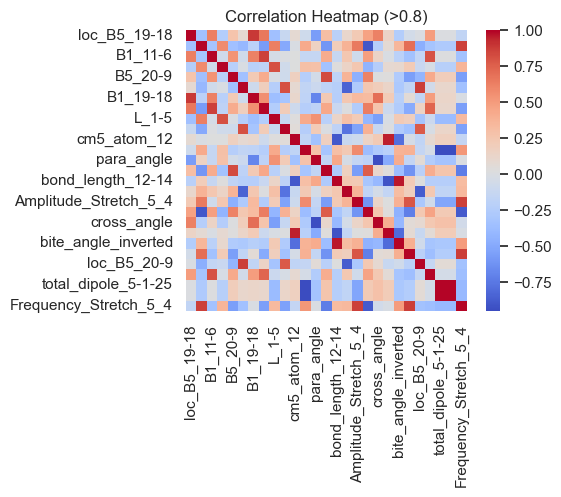


Correlated features were not dropped.

Starting generate_and_display_q2_scatter_plot...
Extracting features from model.features_df...
Data normalized. Variance: 1.00
Using Leave-One-Out cross-validation (LOO)...
R2:0.809 Q2: 0.767, MAE: 0.313, RMSD: 0.372 for combination: ['dipole_z_10-11-12', 'hirshfeld_atom_12']
Training Set Results: {'r2': 0.8091010052420691, 'Q2': 0.7669550682995583, 'MAE': 0.31342394099480086, 'RMSD': 0.37245115762449743}
Calculating cross-validation metrics for 3-fold CV...
Data normalized. Variance: 1.00
Using 3-Fold cross-validation...
3-fold CV metrics: Q2: 0.7772927209328689, MAE: 0.30673947123620293, RMSD: 0.3640966669540886
Calculating cross-validation metrics for 5-fold CV...
Data normalized. Variance: 1.00
Using 5-Fold cross-validation...
5-fold CV metrics: Q2: 0.7657072355975673, MAE: 0.3106843490356241, RMSD: 0.37344696615642303
Calculating cross-validation metrics for LOOCV...
Data normalized. Variance: 1.00
Using Leave-One-Out cross-validation (LOO).

C:\Users\edens\Documents\GitHub\LabCode\MolFeatures\M3_modeler\plot.py:293: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Plot generated successfully.
Finished generate_and_display_q2_scatter_plot.


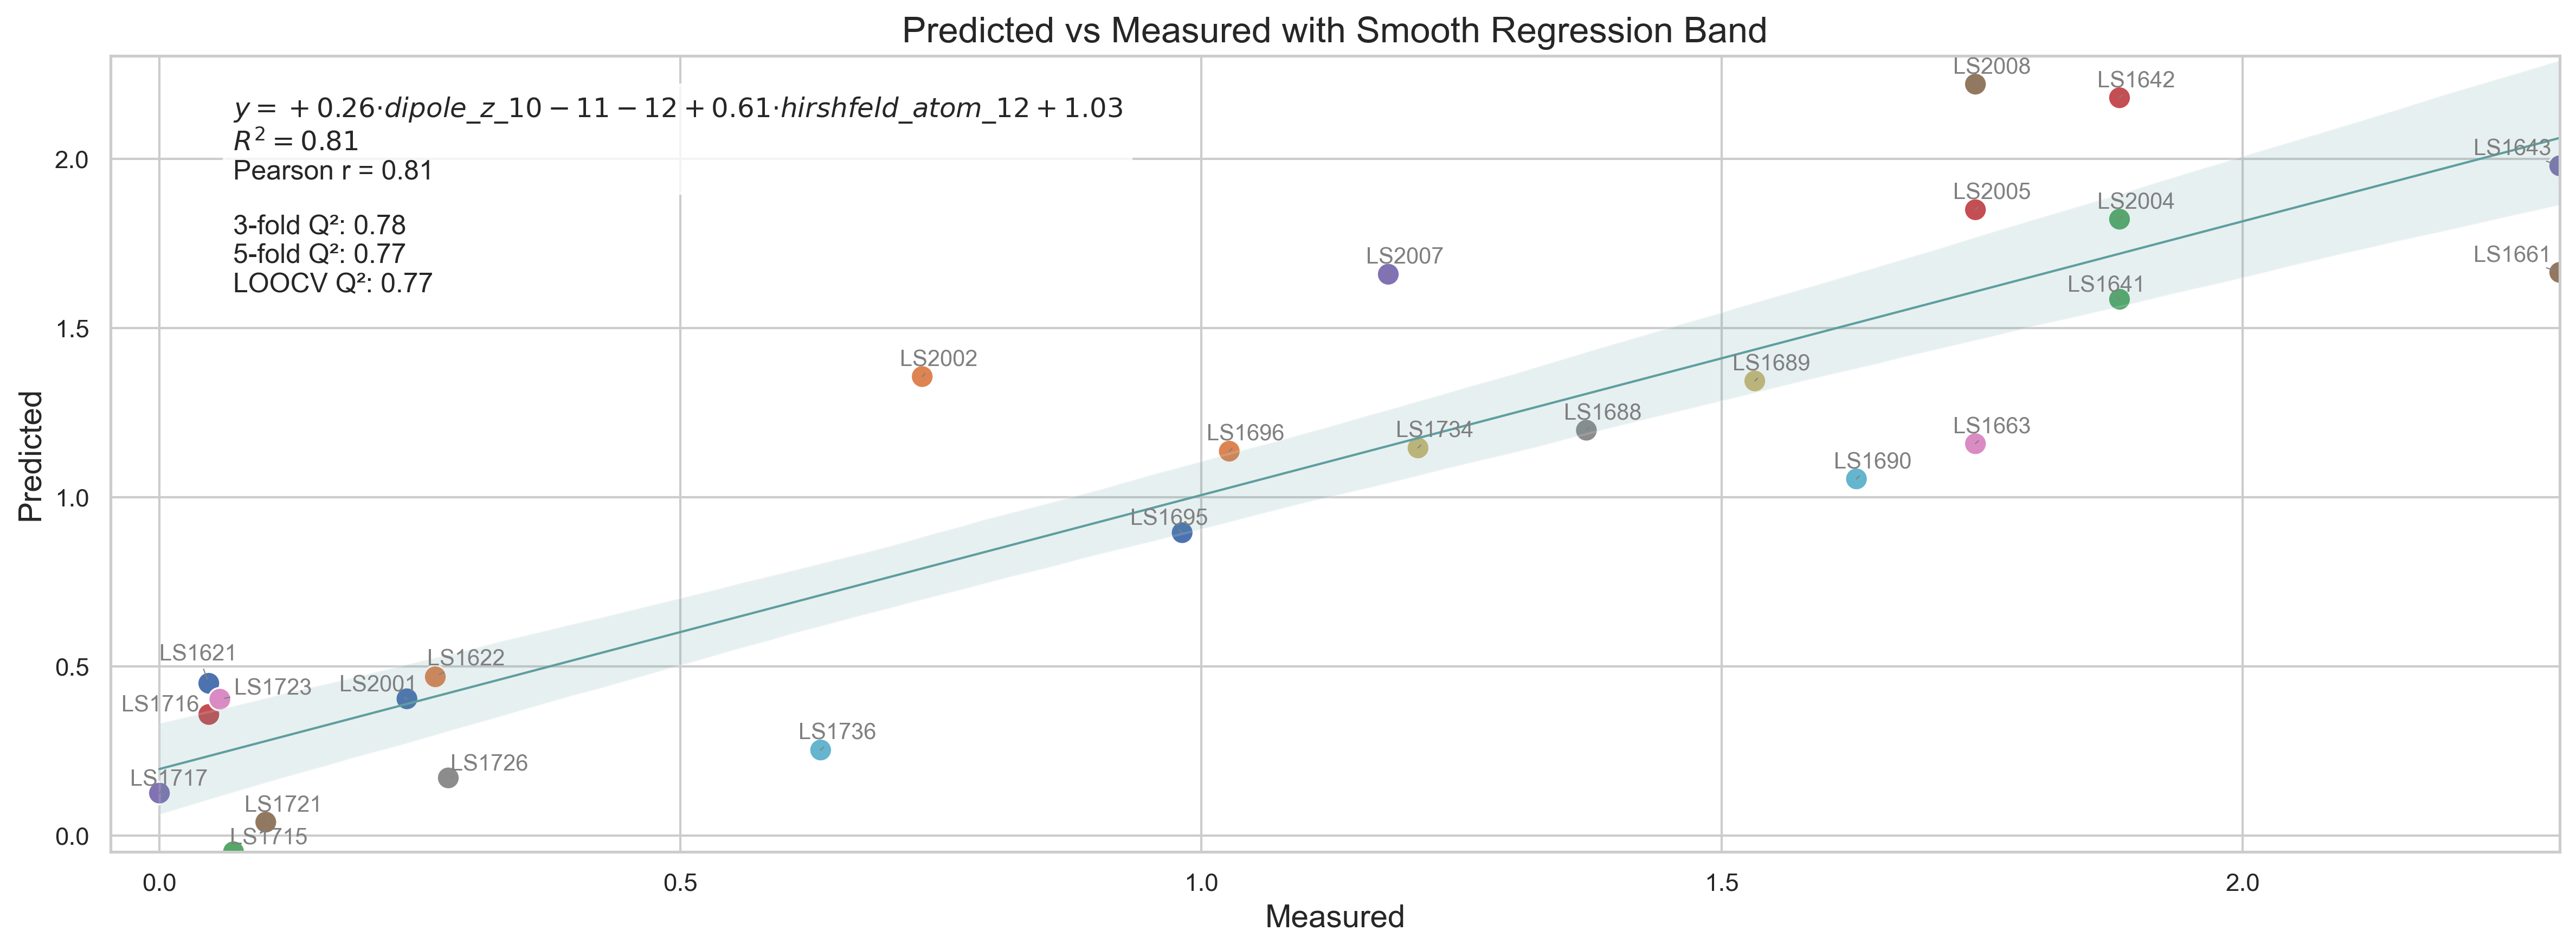

In [95]:


os.chdir(r'C:\Users\edens\Documents\GitHub\Robert')  # Reset working directory
csv_path=r'C:\Users\edens\Documents\GitHub\Robert\added_features_new_version.csv'

# csv_path=r'C:\Users\edens\Documents\GitHub\lucas_project\new_update_logs\added_features_try34.csv'

csv_filepaths = {
'features_csv_filepath': csv_path,
'target_csv_filepath': ''
}
# ['LS2008','LS1643']
# ('B1_B5_angle_4-3', 'L_11-6', 'bond_length_11-12')
df=pd.read_csv(csv_path, index_col=0)

# df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
leave_out = [
    "LS1621", "LS1622",  "LS1641", "LS1642", "LS1643",
    "LS1661", "LS1663", "LS1715", "LS1716", "LS1717",
    "LS1721", "LS1723", "LS1726", "LS1734", "LS1736",
    "LS2000", "LS2001", "LS2002", "LS2003",  "LS2007", "LS2008"
]
y=df['output']
leave_out = pick_samples_to_remove_for_distribution(y, n_remove=4, plot=True)
print(f"Samples to leave out: {leave_out}")
# pick 4 random samples to leave out
# leave_out = np.random.choice(df.index, size=2, replace=False).tolist()
leave_out=['LS2000', 'LS2003', 'LS1687', 'LS1685'] # 

Regression_model = LinearRegressionModel(csv_filepaths, process_method='one csv', output_name='output', leave_out=leave_out, min_features_num=4, max_features_num=4, metrics=None, return_coefficients=False)

features=['dipole_z_10-11-12', 'hirshfeld_atom_12']

r=['hirshfeld_atom_4', 'Frequency_Stretch_12_21']
# ('B1_B5_angle_4-3', 'L_11-6', 'bond_length_11-12')
# x=Regression_model.check_linear_regression_assumptions()
# Regression_model.fit_and_evaluate_combinations()
plot.generate_and_display_q2_scatter_plot(Regression_model,features)


TreeExplainer failed: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <modeling.LinearRegressionModel object at 0x0000020D8EC72F40>. Falling back to KernelExplainer.


  0%|          | 0/29 [00:00<?, ?it/s]

Error creating explainer: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <modeling.LinearRegressionModel object at 0x0000020D8EC72F40>


  0%|          | 0/29 [00:00<?, ?it/s]

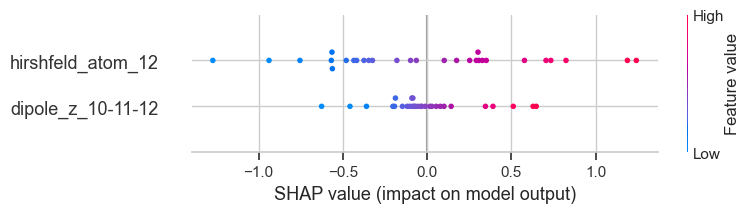

Error creating explainer: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <modeling.LinearRegressionModel object at 0x0000020D8EC72F40>


  0%|          | 0/29 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

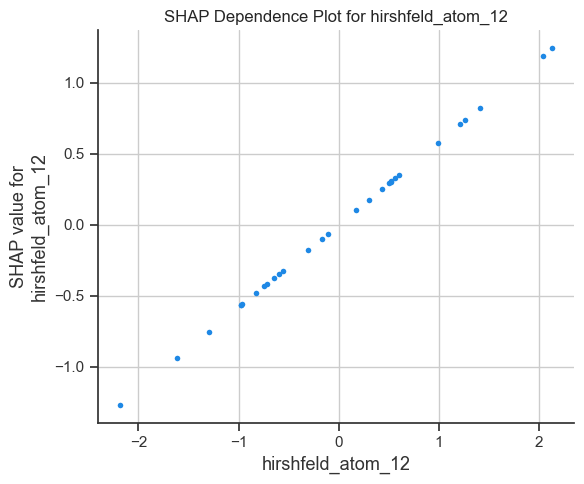

Error creating explainer: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <modeling.LinearRegressionModel object at 0x0000020D8EC72F40>


  0%|          | 0/29 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

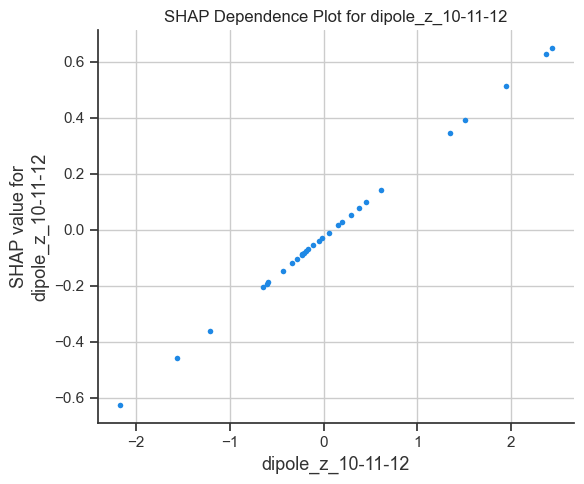

{'shap_values': array([[-0.03925619, -0.56858349],
        [-0.0311642 ,  0.57777138],
        [-0.2031799 ,  1.24180994],
        [ 0.10021363,  0.82419601],
        [-0.10392413,  0.70555568],
        [ 0.34619948,  0.35113943],
        [ 0.14267693, -0.17944324],
        [ 0.39084588, -0.09842058],
        [ 0.51136213, -0.06415957],
        [-0.11788542,  0.17497302],
        [-0.4577986 ,  0.3019471 ],
        [-0.19364126,  0.30738719],
        [-0.01063942, -1.27197591],
        [ 0.05395548, -0.9382783 ],
        [-0.07056745, -0.48015304],
        [ 0.01626619, -0.75481986],
        [-0.62630992, -0.32435805],
        [-0.07721288, -0.43478036],
        [-0.35989645, -0.41846008],
        [ 0.07835164,  0.10147389],
        [-0.08453096, -0.56233317],
        [-0.05566563, -0.37493934],
        [-0.18812273, -0.34634991],
        [ 0.02828253,  0.32810584],
        [ 0.6477504 ,  0.25252328],
        [ 0.62887476,  0.29222438],
        [-0.08809223, -0.5648796 ],
        [-0.1

In [8]:
plot.analyze_shap_values(Regression_model, Regression_model.features_df[list(features)], feature_names=features, target_name=Regression_model.output_name, n_top_features=10)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def check_y_distribution(y, zero_threshold=0.25, plot=True):
    """
    Check if y values are well-spread for linear regression.

    Parameters
    ----------
    y : array-like
        Target values for regression.
    zero_threshold : float
        Fraction of zeros above which a warning is issued.
    plot : bool
        If True, plot histogram and boxplot.

    Returns
    -------
    result : dict
        Summary statistics and warning flag.
    """
    y = np.array(y)
    n_total = len(y)
    n_zeros = np.sum(y == 0)
    frac_zeros = n_zeros / n_total
    summary = {
        'n_total': n_total,
        'n_zeros': n_zeros,
        'frac_zeros': frac_zeros,
        'min': float(np.min(y)),
        'max': float(np.max(y)),
        'mean': float(np.mean(y)),
        'std': float(np.std(y)),
        'warning': frac_zeros > zero_threshold
    }
    print(f"Total values: {n_total}")
    print(f"Zero values: {n_zeros} ({frac_zeros:.1%})")
    print(f"Min: {summary['min']:.3f} | Max: {summary['max']:.3f} | Mean: {summary['mean']:.3f} | Std: {summary['std']:.3f}")
    if summary['warning']:
        print(f"⚠️ Warning: {frac_zeros:.1%} of y values are zero! This may bias regression.")

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].hist(y, bins=30, color='steelblue', edgecolor='k')
        axes[0].set_title('y Value Histogram')
        axes[0].set_xlabel('y')
        axes[0].set_ylabel('Count')
        axes[1].boxplot(y, vert=False)
        axes[1].set_title('y Value Boxplot')
        plt.tight_layout()
        plt.show()

    return summary

check_y_distribution(Regression_model.y, zero_threshold=0.25, plot=True)

AttributeError: 'LinearRegressionModel' object has no attribute 'y'